In [1]:
# Base packages
import os
import numpy as np
import pandas as pd
import json

# Web scraping
from bs4 import BeautifulSoup
import requests

# Misc
from tqdm import tqdm

# Web scraping and data cleaning

##

After investigating https://www.climate-laws.org/ with Edge's Developer Console, I've found out that the website's React app gets its JSON data from this link https://www.climate-laws.org/legislation_and_policies.json?offset=[offset]. This will allow me to batch request the data straight from the website's back-end, instead of scraping and cleaning static HTML files.

In [2]:
# Function to request data
def request_climate_laws_data(offset_batch=np.arange(10, 2100, 10)):
    """
    Get online Climate Laws data from climate-laws.org, and process it into DataFrame
    """
    climate_laws_df = pd.DataFrame()
    for offset in tqdm(offset_batch):
        climate_laws_url = f"https://www.climate-laws.org/legislation_and_policies.json?offset={offset}"
        climate_laws_data = requests.get(climate_laws_url)
        climate_laws_df = climate_laws_df.append(climate_laws_data.json()["items"])
    return climate_laws_df.reset_index()

In [3]:
climate_laws_df = request_climate_laws_data(np.arange(10, 2100, 10))

100%|████████████████████████████████████████████████████████████████████████████████| 209/209 [00:38<00:00,  5.42it/s]


In [4]:
# Exploring dataset
print(f"Data shape: {climate_laws_df.shape}")
print(f"Columns:\n{climate_laws_df.columns}")
climate_laws_df.head()

Data shape: (2086, 23)
Columns:
Index(['index', 'id', 'title', 'description', 'law_id', 'slug', 'geography_id',
       'created_at', 'updated_at', 'visibility_status', 'created_by_id',
       'updated_by_id', 'discarded_at', 'legislation_type', 'parent_id',
       'date', 'link', 'short_description', 'geography', 'date_passed',
       'last_change', 'legislation_type_humanize', 'geography_path'],
      dtype='object')


,index,id,title,description,law_id,slug,geography_id,created_at,updated_at,visibility_status,...,legislation_type,parent_id,date,link,short_description,geography,date_passed,last_change,legislation_type_humanize,geography_path
0,0,9737,Plan to Control Illegal Deforestation and Reco...,<div>This plan aims to continuously and consis...,None,plan-to-control-illegal-deforestation-and-reco...,24,2020-11-17T13:43:31.244Z,2020-11-17T13:51:05.342Z,published,...,executive,NaN,2020-10-25,"<a href=""/geographies/brazil/policies/plan-to-...",This plan aims to continuously and consistentl...,"{'id': 24, 'geography_type': 'national', 'iso'...",2004,"October, 2020",Executive,/geographies/brazil
1,1,9740,Institutional Program of the National Institut...,<div>The agreement that creates the Institutio...,None,institutional-program-of-the-national-institut...,114,2020-12-04T17:29:29.757Z,2020-12-04T17:33:08.878Z,published,...,executive,NaN,2020-10-16,"<a href=""/geographies/mexico/policies/institut...",The agreement that creates the Institutional P...,"{'id': 114, 'geography_type': 'national', 'iso...",2020,None,Executive,/geographies/mexico
2,2,1657,Electricity Utility Act,<div>The Electricity Business Law mandates bot...,None,electricity-utility-act,166,2019-12-08T17:46:16.862Z,2020-06-29T15:45:25.525Z,published,...,legislative,NaN,2020-10-01,"<a href=""/geographies/south-korea/laws/electri...",The Electricity Business Law mandates both the...,"{'id': 166, 'geography_type': 'national', 'iso...",1990,"October, 2020",Legislative,/geographies/south-korea
3,3,9732,Circular No. 25/2020 / TT-BCT on the implement...,<div>This circular was adopted by the Minister...,None,circular-no-25-2020-tt-bct-on-the-implementati...,197,2020-10-31T13:46:44.180Z,2020-10-31T13:46:44.180Z,published,...,executive,NaN,2020-09-29,"<a href=""/geographies/vietnam/policies/circula...",This circular was adopted by the Minister of I...,"{'id': 197, 'geography_type': 'national', 'iso...",2020,None,Executive,/geographies/vietnam
4,4,9728,Framework law for the use and promotion of bic...,<div>The main objective of this law is to gene...,None,framework-law-for-the-use-and-promotion-of-bic...,54,2020-10-26T21:17:32.493Z,2020-10-29T16:08:05.326Z,published,...,legislative,NaN,2020-09-25,"<a href=""/geographies/el-salvador/laws/framewo...",The main objective of this law is to generate ...,"{'id': 54, 'geography_type': 'national', 'iso'...",2020,None,Legislative,/geographies/el-salvador


In [5]:
from datetime import datetime

# Saving data to use later, instead of requesting from server
os.makedirs("./climate_laws_data", exist_ok=True)
timestamp = datetime.now().strftime("%Y.%m.%d_%H.%M.%S")

climate_laws_df.to_excel(f"./climate_laws_data/{timestamp}_climate_laws_data.xlsx", index=False)

### EDA and data cleaning

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\ZH834BT\AppData\Local\Continuum\anaconda3_python\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


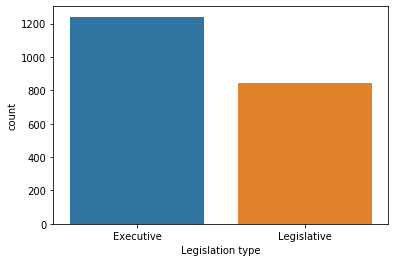

In [7]:
# Types of legislation
legislation_type_plot = sns.countplot(x="legislation_type_humanize", data=climate_laws_df)
plt.xlabel("Legislation type")
plt.show()

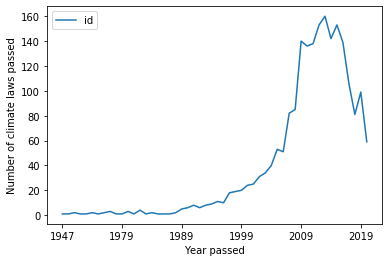

Year with maximum number of laws passed


,date_passed,id
44,2013,160


In [33]:
# Date passed - seeing the distribution of pass date of the laws
date_passed_count_df = pd.DataFrame(pd.pivot_table(values="id", index="date_passed", aggfunc='count', data=climate_laws_df).to_records())
date_passed_count_df.plot(x="date_passed", ylabel="Number of climate laws passed", xlabel="Year passed")
plt.show()

print("Year with maximum number of laws passed")
date_passed_count_df[date_passed_count_df["id"] == date_passed_count_df["id"].max()]

#### Observations:
The figure above is interesting. 

The number of laws passed started to skyrocket around 1999 and continue to rise until 2013, after which we see a marked decline.

Additionally, we see that 2013 has the highest number of climate laws passed, it will be interesting to see which countries contribute to these? As well as which topics (topic modelling will come later)

#### Provisional research question:

"What factors explain the presence of climate laws in a given year?"

In [36]:
# Extracting country name from geography column
def extract_country_name(df):
    return df["geography"]["name"]
climate_laws_df.loc[:, "country_name"] = climate_laws_df.apply(lambda x: extract_country_name(x), axis=1)

In [42]:
# Investigating which countries pass to the Climate laws in 2013
def country_laws_year_passed(year=2013):
    count_df = pd.DataFrame(pd.pivot_table(values="id", index="country_name", aggfunc="count",
                                          data=climate_laws_df[climate_laws_df["date_passed"]==str(year)]).to_records())
    return count_df

In [66]:
# Seeing the Top five countries passing highest number of climate laws in 2013
country_laws_year_passed(year=2013).sort_values("id", ascending=False).head()

,country_name,id
81,Spain,8
31,European Union,5
15,Burkina Faso,5
12,Brazil,5
18,Chile,4


In [74]:
# I've found it a bit surprising to see Burkina Faso on this list, let's investigate which laws were passed
# Helper function
def print_laws_title_country_year(country, year):
    print(f"// {country} - {str(year)}: //")
    for item in climate_laws_df[(climate_laws_df["country_name"]==country) & 
                    (climate_laws_df["date_passed"]==str(year))]["title"]:
        print(item)

print_laws_title_country_year("Burkina Faso", 2013)

// Burkina Faso - 2013: //
National multi-risk plan for disaster preparedness and response
Decree no. 2013-325 (establishing the mission of a national entity responding to climate change)
Law no. 006-2013 (on the Code for the Environment)
Decree no. 2013-151 (on the National Council for the Environment and Sustainable Development)
Law of finance 2013 relative to the deletion of customs charges on equipments and material of solar energy


#### Observation:

Upon further observations, I noticed that the "geography" column contains a lot of useful information, such as the country's World Bank Income Group, Climate Risk index, Percent of Global Emissions, etc. It will be very useful to bring these information into the columns of the main DataFrame.

In [63]:
# Enriching data with more useful information from "geography column"
def percent_global_emissions(df):
    return df["geography"]["percent_global_emissions"]

def climate_risk_index(df):
    return df["geography"]["climate_risk_index"]

def wb_income_group(df):
    return df["geography"]["wb_income_group"]

def eu_member_ind(df):
    return df["geography"]["eu_member"]

def visibility_status(df):
    return df["geography"]["visibility_status"]

def law_discarded_at(df):
    return df["geography"]["discarded_at"]

# Adding columns
for func, name in zip([percent_global_emissions, climate_risk_index, wb_income_group, eu_member_ind, visibility_status, law_discarded_at],
                     ["percent_global_emissions", "climate_risk_index", "wb_income_group", "eu_member_ind", "visibility_status", "law_discarded_at"]):
    climate_laws_df.loc[:, name] = climate_laws_df.apply(lambda x: func(x), axis=1)

In [80]:
# Seeing number of laws passed per WB Income Group
pd.DataFrame(pd.pivot_table(values="id", index="wb_income_group", aggfunc="count", data=climate_laws_df).to_records())

,wb_income_group,id
0,High income,735
1,Low income,237
2,Lower middle income,499
3,Upper middle income,528


In [81]:
timestamp = datetime.now().strftime("%Y.%m.%d_%H.%M.%S")
climate_laws_df.to_excel(f"./climate_laws_data/{timestamp}_climate_laws_data_expanded.xlsx", index=False)